# Aktivációs függvények


https://en.wikipedia.org/wiki/Activation_function

## Sigmoid

Az egyik leggyakrabban használt aktivációs függvény:
\begin{equation*}
f(x) = \frac{1}{1+e^{-x}}
\end{equation*}
## Tanh

\begin{equation*}
f(x) = tanh(x)
\end{equation*}

## ReLu

Manapság nagyon népszerű, több változata is van, mi csak az eredetit használjuk: 
\begin{equation*}
f(x) = max(0,x)
\end{equation*}

## SoftPlus

Alakja hasonlít a ReLu-hoz, de deriválható 0-ban is. A képlete a Sigmoid függvény integráltja:
\begin{equation*}
f(x) = ln(1+e^{-x})
\end{equation*}

## MNIST adatbázis

![MNIST adatbázis](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)
Az adatbázis kézzel írt számokról készült képeket tartalmaz. Összesen 60000 db példa található a tanító adatbázisban és 10000 a teszt halmazban. A képeket egységes méretre hozták (28x28 pixel) és minden pixel intenzitását 0 és 1 közé normalizáltak. A képek 1-D-s numpy tömbökben vannak tárolva.

Bővebben: http://yann.lecun.com/exdb/mnist/

Első lépésben telepítsük a matplotlib csomagot, majd improtáljuk a szükséges csomagokat és betöltjük az adatbázist a /tmp/data könyvtárból.

In [1]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


A következő lépés a tanítási paraméterek és a neuronháló strukturához a változók inicializálása.

In [2]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

Készíthetünk saját aktivációs függvényt is: célszerű a tensorflows függvényeket használni hozzá.

In [3]:
def custom(x):
    return 2*tf.abs(x)-1

A neuronháló tanításához létrehozunk egy bemeneti függvényt, ami a korábba letöltött adatbázisból ú.n. batch-eket fog készíteni.

In [4]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

A következő kód létrehozza a 2 rejtett réteges hálózatot, különböző aktivációs függvényekkel.

In [5]:
# Define the neural network
def neural_net(x_dict, act_fn):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    layer_1 = tf.layers.dense(x, n_hidden_1, activation=act_fn)
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=act_fn)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_2, num_classes)
    return out_layer

A tanításhoz szükséges dolgok beállítása:
- neuronháló kimenetének kezelése
- loss függvény megadása
- hibametrika választása
- ** aktivációs függvény ** 

Feladat: a neural_net függvény hívásánál cseréljük le az aktivációs függvényt!
Néhány lehetőség:
- None (linearis)
- tf.nn.sigmoid
- tf.nn.tanh
- tf.nn.relu
- tf.nn.softplus
- custom

További lehetőségek: https://www.tensorflow.org/api_docs/python/tf/nn

In [6]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):

    # Build the neural network
    logits = neural_net(features, None) 
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

### Neuronháló tanítása
Megfigyelhető, hogy minden 100. step után közöl információt és 1000 lépésig fut (ezeket feljebb állítottuk be).
Tanítás során célszerű figyelni a loss értékét, illetve a validációs pontosságot, azok alapján tudjuk beállítani a tanulási paramétereket. 

In [7]:
# Train the Model
model = tf.estimator.Estimator(model_fn)
model.train(input_fn, steps=num_steps)
model.evaluate(input_fn, steps=100) #Validation

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9f352cb790>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmp0K8jlb', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp0K8jlb/model.ckpt.
INFO:tensorflow:loss = 2.56652, step = 1
INFO:tensorflow:global_step/sec: 94.8385
INFO:tensorflow:loss = 0.39849, step = 101 (1.063 sec)
INFO:tensorflow:global_step/sec: 89.0799
INFO:tensorflow:loss = 0.199782, step = 201 (1.128 sec)
INFO:tensorflow:global_step/sec: 90.9892
INFO:tensorflow:loss = 0.225227

{'accuracy': 0.91632813, 'global_step': 1000, 'loss': 0.29472196}

Tanítás után kiértékelünk a teszt halmazon.
**Fontos: csak a legjobb modellünket értékeljük ki a teszt halmazon, különben peeking-elünk.**

Peeking (kukucskálás): a teszt halmazon látott teljesítmény alapján optimalizáljuk az algoritmusunk paramétereit ezért nem tudjuk hogy az milyen jól általánosít.

In [8]:
# Evaluate the Model
# Define the input function for evaluating
input_fn_test = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn_test)

INFO:tensorflow:Starting evaluation at 2018-09-27-09:06:31
INFO:tensorflow:Restoring parameters from /tmp/tmp0K8jlb/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-09-27-09:06:32
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9153, global_step = 1000, loss = 0.293047


{'accuracy': 0.91530001, 'global_step': 1000, 'loss': 0.29304677}

Kiértékelhetünk csak néhány példát is a következő módon:

INFO:tensorflow:Restoring parameters from /tmp/tmpu7vjLA/model.ckpt-1000


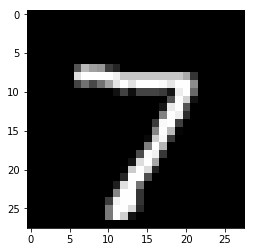

Model prediction: 7


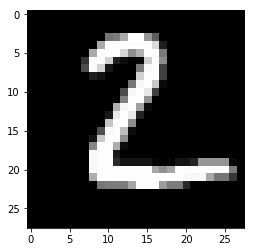

Model prediction: 2


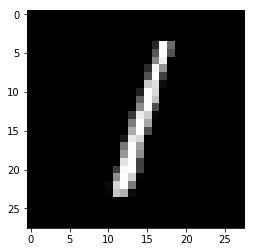

Model prediction: 1


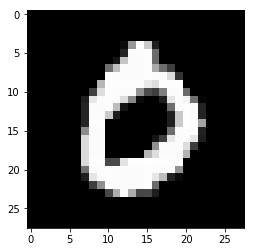

Model prediction: 0


In [9]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn_test_few = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn_test_few))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

### Feladatok
1. Készítsünk validációs halmazt! (Pl a tanítópéldák 10%-át csak validációra használjuk)
2. Találjunk ki új aktivációs függvényt!
3. Keressük meg, hogy mely képeken hibázott a háló!
4. Változtassuk a neuronok számát, a batch méretet és a num_step értékét!
5. Adjunk hozzá a neuronhálóhoz további rejtett rétegeket!